In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras_preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG19

from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
# from tensorflow.keras.models import Sequential


In [3]:
csv_file = "corrected_csv_file.csv"
data = pd.read_csv(csv_file)
data.head(10)

,Sample No,Image Name,SPAD Value
0,1,IMG_3547.JPG,89.9
1,1,IMG_3548.JPG,89.9
2,1,IMG_3549.JPG,89.9
3,1,IMG_3550.JPG,89.9
4,1,IMG_3551.JPG,89.9
5,1,IMG_3552.JPG,89.9
6,1,IMG_3556.JPG,89.9
7,2,IMG_3557.JPG,98.7
8,2,IMG_3558.JPG,98.7
9,2,IMG_3559.JPG,98.7


In [4]:
image_folder = "capscum_org3/"
weights_path = "VGG_19\saved_model.pb"

In [5]:
weights_path

'VGG_19\\saved_model.pb'

LOAD THE DATA

In [6]:
def load_data(dataframe, image_folder):
    images = []
    labels = []
    for _, row in dataframe.iterrows():
        img_path = image_folder + row["Image Name"]
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images.append(image)
        labels.append(row["SPAD Value"])
    return np.array(images), np.array(labels)

In [7]:
images, labels = load_data(data, image_folder)

In [8]:
images = images / 255.0

In [9]:
images

array([[[[0.17254902, 0.13725491, 0.11764706],
         [0.5921569 , 0.5803922 , 0.60784316],
         [0.6117647 , 0.5921569 , 0.6156863 ],
         ...,
         [0.1254902 , 0.07058824, 0.05882353],
         [0.11372549, 0.07058824, 0.05490196],
         [0.11764706, 0.07450981, 0.05882353]],

        [[0.30588236, 0.2627451 , 0.25490198],
         [0.61960787, 0.5803922 , 0.6156863 ],
         [0.6392157 , 0.59607846, 0.627451  ],
         ...,
         [0.14509805, 0.07450981, 0.05882353],
         [0.14117648, 0.06666667, 0.04313726],
         [0.11372549, 0.07058824, 0.04705882]],

        [[0.60784316, 0.56078434, 0.56078434],
         [0.627451  , 0.5882353 , 0.62352943],
         [0.64705884, 0.6039216 , 0.63529414],
         ...,
         [0.15686275, 0.09019608, 0.0627451 ],
         [0.15294118, 0.07843138, 0.05098039],
         [0.1254902 , 0.08235294, 0.05882353]],

        ...,

        [[0.7529412 , 0.7294118 , 0.78431374],
         [0.7490196 , 0.72156864, 0.78431374]

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
for train_index, test_index in kf.split(images):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


In [13]:
X_train[0].shape

(224, 224, 3)

In [14]:
print(len(y_test))
print(len(y_train))
print(len(y_val))

35
99
43


In [15]:
base_model = VGG19(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
# base_model.load_weights(weights_path)
base_model.trainable = False

In [16]:
# model = Sequential([
#         base_model,
#         Conv2D(32, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
        
#         Dense(512, activation='relu'),
#         Dropout(0.5),
        
#         Conv2D(32, 3, padding='same', activation='relu'),
#         MaxPooling2D(),

#         Dense(256, activation='relu'),
#         Dropout(0.6),
#         Dense(128, activation='relu'),
        
#         Conv2D(32, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
        
#         Dropout(0.5),
#         Dense(64, activation='sigmoid'),
#         Dropout(0.5),
#         Dense(1, activation='linear')
#     ])

In [17]:
model = Sequential([
        base_model,
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='tanh'),
        Dropout(0.6),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='sigmoid'),
        Dropout(0.5),
        Dense(1, activation='linear')
    ])

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [27]:
history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=3000,  # Reduced number of epochs to avoid overfitting with small dataset
        verbose=1  # Suppress training output for clarity
    )

Epoch 1/3000
4/4 [==============================] - 2s 347ms/step - loss: 695.6638 - mae: 22.0809 - mse: 695.6638 - val_loss: 586.1052 - val_mae: 20.9243 - val_mse: 586.1052
Epoch 2/3000
4/4 [==============================] - 1s 329ms/step - loss: 693.0706 - mae: 22.0191 - mse: 693.0706 - val_loss: 585.7941 - val_mae: 20.9176 - val_mse: 585.7941
Epoch 3/3000
4/4 [==============================] - 1s 331ms/step - loss: 696.0129 - mae: 22.0661 - mse: 696.0129 - val_loss: 585.4027 - val_mae: 20.9093 - val_mse: 585.4027
Epoch 4/3000
4/4 [==============================] - 1s 333ms/step - loss: 695.1730 - mae: 22.0241 - mse: 695.1730 - val_loss: 585.1512 - val_mae: 20.9039 - val_mse: 585.1512
Epoch 5/3000
4/4 [==============================] - 1s 332ms/step - loss: 691.8340 - mae: 21.9974 - mse: 691.8339 - val_loss: 584.8871 - val_mae: 20.8983 - val_mse: 584.8870
Epoch 6/3000
4/4 [==============================] - 1s 330ms/step - loss: 693.0876 - mae: 22.0088 - mse: 693.0876 - val_loss: 584.

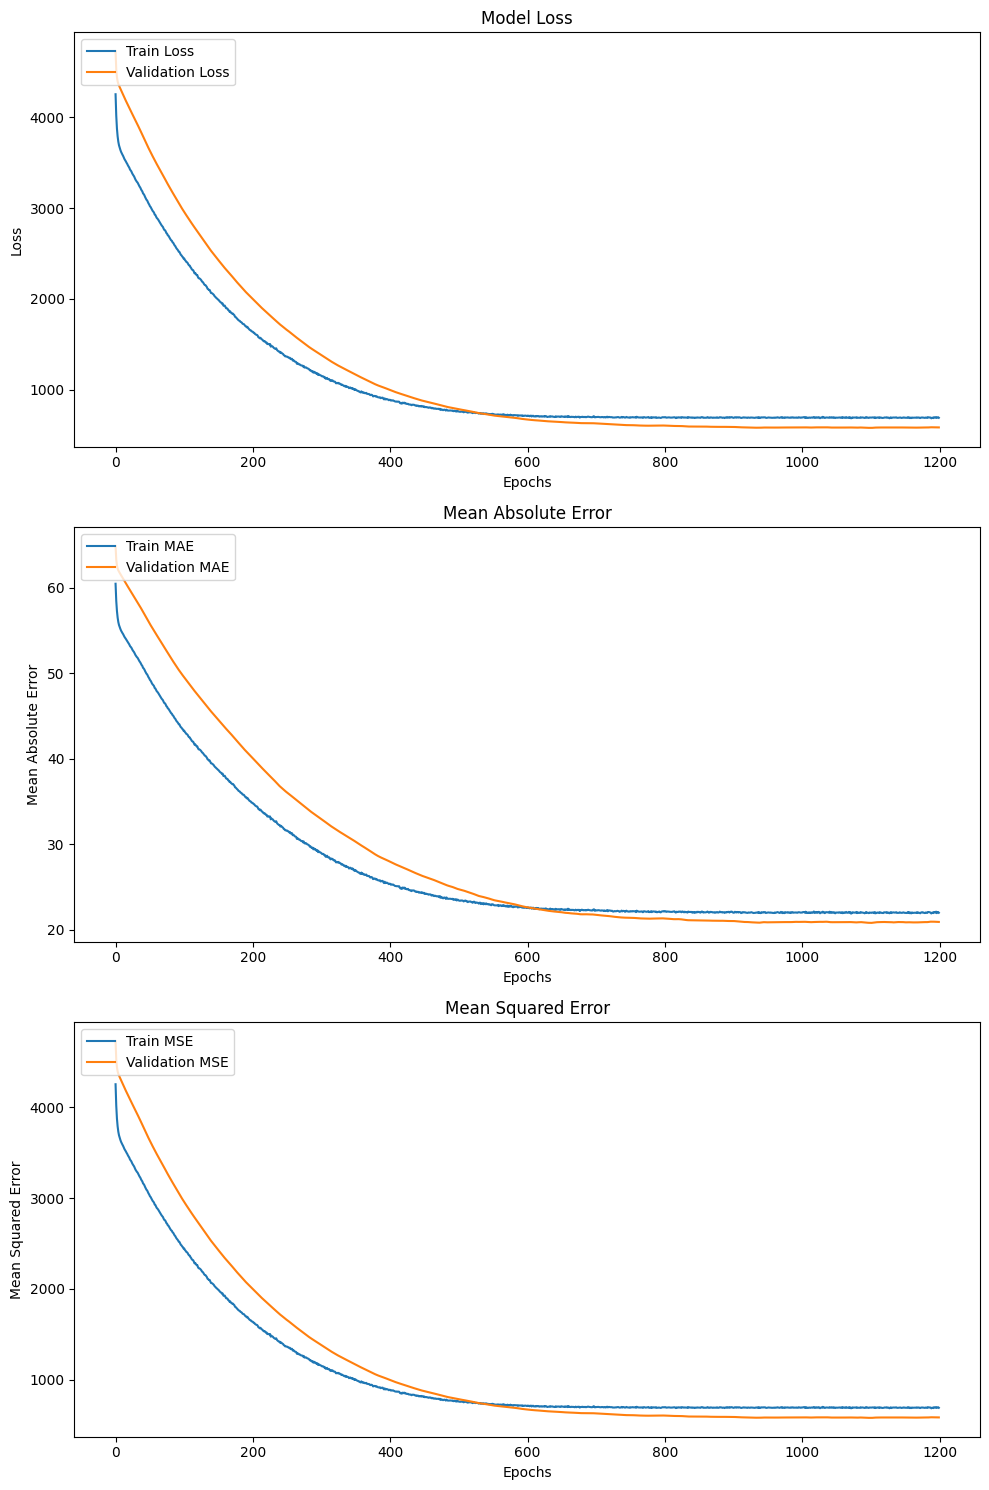

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot training and validation loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper left')

axs[1].plot(history.history['mae'], label='Train MAE')
axs[1].plot(history.history['val_mae'], label='Validation MAE')
axs[1].set_title('Mean Absolute Error')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Mean Absolute Error')
axs[1].legend(loc='upper left')

axs[2].plot(history.history['mse'], label='Train MSE')
axs[2].plot(history.history['val_mse'], label='Validation MSE')
axs[2].set_title('Mean Squared Error')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Mean Squared Error')
axs[2].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
y_pred = model.predict(X_test)
print(f'Shape of y_pred before flattening: {y_pred.shape}')
y_pred_reshaped = y_pred.mean(axis=(1, 2, 3)).flatten()

print(f'Shape of y_pred after reshaping: {y_pred_reshaped.shape}')

KeyboardInterrupt: 

In [22]:
fold_mae = []
fold_mse = []

In [23]:
mae = mean_absolute_error(y_test, y_pred_reshaped)
mse = mean_squared_error(y_test, y_pred_reshaped)
    
fold_mae.append(mae)
fold_mse.append(mse)
    
print(f'Fold MAE: {mae}, Fold MSE: {mse}')

Fold MAE: 18.705610002790177, Fold MSE: 568.9519405020093


In [24]:
avg_mae = np.mean(fold_mae)
avg_mse = np.mean(fold_mse)

print(f'Average MAE: {avg_mae}, Average MSE: {avg_mse}')

Average MAE: 18.705610002790177, Average MSE: 568.9519405020093


In [26]:
#model.save('vgg19_model(for integratrion 1200 epcoh).keras')